## Packages

In [1]:
import pandas as pd
import numpy as np
from math import ceil
from itertools import product
## import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import sqlalchemy 
from sqlalchemy import create_engine, text

import sys
import os

## Add the path of the functions folder
current_dir = os.getcwd()  ## Gets the current working directory
sub_dir = os.path.abspath(os.path.join(current_dir, '..'
                                       , 'Functions'))
sys.path.append(sub_dir)

# Now you can import functions
from db_secrets import SQL_107

from visualisations import plot_prediction_error, plot_prediction_density_subplots

from helpers import aggregate_sites, keras_calculate_accuracy, keras_calculate_baseline_accuracy

In [340]:
# TensorFlow sequential model
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM

from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [3]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Connection

In [4]:
## text for query
with open("../Exploratory_Analysis/111_sql.sql", "r") as file:
    query_text = file.read()

query_text = query_text.replace('REPLACE START DATE','2022-01-01')

In [6]:
## Create an engine + connection
engine = create_engine(SQL_107())
conn = engine.connect()

## Return data
df_raw = pd.read_sql(query_text,conn)

## Wrangle

In [610]:
## Makes working copy
df = df_raw.copy()

#df = df.sample(n=100000, random_state=42)

In [611]:
## List columns
df.columns

Index(['Start_Location', 'Call ID', 'Pseudo NHS Number', 'CallDate',
       'Call Connect Time', 'Weekday_Name', 'Week_Start', 'Financial Year',
       'Bank Holiday', 'In_Out_Hours', 'Sub ICB Code', 'Sub ICB Name',
       'GP Practice', 'GP Practice Code', 'GP Deprivation',
       'GP Survey Q21 Wait for Appt', 'Symptom_Group',
       'Final Disposition Code', 'Disposition Group', 'Disposition',
       'Call_Taker_Triages', 'Clinical_Triages', 'Patient Age', 'Patient Sex',
       'Outcome ID', 'Outcome Datetime', 'Outcome Type', 'Outcome',
       'Outcome Location Code', 'Outcome Location Name', 'Hours to Outcome'],
      dtype='object')

In [612]:
df = df[['Call Connect Time'
         ,'Outcome Location Name'
         ,'Bank Holiday'
         , 'In_Out_Hours'
         , 'Sub ICB Name'
         ,'Outcome Type']].copy()

In [613]:
## Round time to nearest hour
df['Call Connect Time'] = df['Call Connect Time'].dt.round(freq='h')


In [614]:
## Replaces low frequency sites with 'OTHER SITE'
df['Outcome Location Name'] = (df['Outcome Location Name']
                               .apply(lambda x: aggregate_sites(x)))

In [615]:
df.head()

,Call Connect Time,Outcome Location Name,Bank Holiday,In_Out_Hours,Sub ICB Name,Outcome Type
0,2022-01-05 01:00:00,No UEC Contact,No,Out of Hours,Tees Valley,No UEC Contact
1,2022-01-05 00:00:00,No UEC Contact,No,Out of Hours,Newcastle Gateshead,No UEC Contact
2,2022-01-05 01:00:00,No UEC Contact,No,Out of Hours,Tees Valley,No UEC Contact
3,2022-01-05 01:00:00,No UEC Contact,No,Out of Hours,Newcastle Gateshead,No UEC Contact
4,2022-01-05 02:00:00,No UEC Contact,No,Out of Hours,Newcastle Gateshead,No UEC Contact


#### binary outcome

In [616]:
df['Calls'] = 1

In [617]:
df['Outcome'] = df['Outcome Type'].transform(lambda x: 0 if x == 'No UEC Contact' else 1)
df = df.drop(['Outcome Type'],axis=1) 

# Reassemble data

#### ICB values

In [618]:
## Aggregates to one column per place per timestamp
df_call = pd.pivot_table(df
                        ,values = 'Calls'
                        ,index = 'Call Connect Time'
                        ,columns ='Sub ICB Name'
                        ,aggfunc ='sum'
                        ,fill_value = 0)

In [619]:
df_call.head()

Sub ICB Name,County Durham,Newcastle Gateshead,North Tyneside,Northumberland,South Tyneside,Sunderland,Tees Valley
Call Connect Time,,,,,,,
2022-01-01 00:00:00,3,4,1,4,0,1,6
2022-01-01 01:00:00,8,5,0,5,1,3,2
2022-01-01 02:00:00,4,3,5,5,1,2,2
2022-01-01 03:00:00,3,4,3,4,1,0,7
2022-01-01 04:00:00,2,2,1,3,0,0,5


#### Site values

In [620]:
df_site = df[df['Outcome']==1]

df_site = df_site[[ 'Call Connect Time'
         , 'Outcome Location Name'
         , 'Outcome'
         ,]].groupby([ pd.Grouper(key='Call Connect Time', freq='1h')
         , 'Outcome Location Name']).agg('sum').reset_index()

In [621]:
## Removes OTHER SITE
df_site = df_site[~(df_site['Outcome Location Name']=='OTHER SITE')]

In [622]:
df_site.head()

,Call Connect Time,Outcome Location Name,Outcome
0,2022-01-01,NORTHUMBRIA SPECIALIST EMERGENCY CARE HOSPITAL,1
1,2022-01-01,QUEEN ELIZABETH HOSPITAL,2
2,2022-01-01,SUNDERLAND ROYAL HOSPITAL,1
3,2022-01-01,UNIVERSITY HOSPITAL OF NORTH DURHAM,1
4,2022-01-01,UNIVERSITY HOSPITAL OF NORTH TEES,1


### Extra time features

In [623]:
df_times = df[['Call Connect Time'
            ,'Bank Holiday'
            , 'In_Out_Hours']].drop_duplicates()

In [624]:
df_times.head()

,Call Connect Time,Bank Holiday,In_Out_Hours
0,2022-01-05 01:00:00,No,Out of Hours
1,2022-01-05 00:00:00,No,Out of Hours
4,2022-01-05 02:00:00,No,Out of Hours
8,2022-01-05 03:00:00,No,Out of Hours
16,2022-01-05 04:00:00,No,Out of Hours


### Assemble

In [625]:
# Get unique timestamps and sites
unique_timestamps = df['Call Connect Time'].unique()
unique_sites = df_site['Outcome Location Name'].unique()

# Create a complete cross join of every site with every timestamp
complete_index = pd.DataFrame(product(unique_timestamps, unique_sites)
                              , columns=['Call Connect Time'
                                         , 'Outcome Location Name'])


In [626]:
## Merge time features
df = complete_index.merge(df_times, on='Call Connect Time', how='left')

In [627]:
## Merge calls + places
df = df.merge(df_call,on='Call Connect Time', how='left').fillna(0)

In [628]:
## Merge sites
df = df.merge(df_site,on=['Call Connect Time'
                           , 'Outcome Location Name'], how='left').fillna(0)

In [629]:
df.head()

,Call Connect Time,Outcome Location Name,Bank Holiday,In_Out_Hours,County Durham,Newcastle Gateshead,North Tyneside,Northumberland,South Tyneside,Sunderland,Tees Valley,Outcome
0,2022-01-05 01:00:00,NORTHUMBRIA SPECIALIST EMERGENCY CARE HOSPITAL,No,Out of Hours,5,5,2,1,0,5,11,0.0
1,2022-01-05 01:00:00,QUEEN ELIZABETH HOSPITAL,No,Out of Hours,5,5,2,1,0,5,11,0.0
2,2022-01-05 01:00:00,SUNDERLAND ROYAL HOSPITAL,No,Out of Hours,5,5,2,1,0,5,11,3.0
3,2022-01-05 01:00:00,UNIVERSITY HOSPITAL OF NORTH DURHAM,No,Out of Hours,5,5,2,1,0,5,11,0.0
4,2022-01-05 01:00:00,UNIVERSITY HOSPITAL OF NORTH TEES,No,Out of Hours,5,5,2,1,0,5,11,2.0


### date time

In [630]:
## Date time conversion to numeric
df['year']    = df['Call Connect Time'].dt.year

df['month sin'] = np.sin(df['Call Connect Time'].dt.month * (2*np.pi/12))
df['month cos'] = np.cos(df['Call Connect Time'].dt.month * (2*np.pi/12))

df['YearDay sin'] = np.sin(df['Call Connect Time'].dt.day_of_year * (2*np.pi/365))
df['YearDay cos'] = np.cos(df['Call Connect Time'].dt.day_of_year * (2*np.pi/365))

df['weekday sin'] = np.sin(df['Call Connect Time'].dt.weekday+1 * (2*np.pi/7))  # Monday=0, Sunday=6
df['weekday cos'] = np.cos(df['Call Connect Time'].dt.weekday+1 * (2*np.pi/7))  # Monday=0, Sunday=6

df['Hour sin'] = np.sin(df['Call Connect Time'].dt.hour * (2*np.pi/24))
df['Hour cos'] = np.cos(df['Call Connect Time'].dt.hour * (2*np.pi/24))

#df = df.drop('Call Connect Time',axis=1) 

df = df.set_index('Call Connect Time')


In [631]:
## One hot encodinng for boolean variables
bool_mapping = {
    'Yes': 1,
    'No': 0,
    'In Hours': 1,
    'Out of Hours': 0
}

df.loc[:,'Is Bank Holiday'] = df['Bank Holiday'].map(bool_mapping)             
df.loc[:,'In Hours'] = df['In_Out_Hours'].map(bool_mapping)
df = df.drop(['Bank Holiday','In_Out_Hours'],axis=1) 

In [632]:
## Dummy variables from Outcome Location Name	
#df = pd.concat([df, pd.get_dummies(df['Outcome Location Name']
#                                   ,dtype=int
#                                   , prefix='Site')]
#                ,axis=1)
#df = df.drop('Outcome Location Name', axis=1)

In [633]:
df.head()

,Outcome Location Name,County Durham,Newcastle Gateshead,North Tyneside,Northumberland,South Tyneside,Sunderland,Tees Valley,Outcome,year,month sin,month cos,YearDay sin,YearDay cos,weekday sin,weekday cos,Hour sin,Hour cos,Is Bank Holiday,In Hours
Call Connect Time,,,,,,,,,,,,,,,,,,,,
2022-01-05 01:00:00,NORTHUMBRIA SPECIALIST EMERGENCY CARE HOSPITAL,5,5,2,1,0,5,11,0.0,2022,0.5,0.866025,0.085965,0.996298,0.241581,-0.970381,0.258819,0.965926,0,0
2022-01-05 01:00:00,QUEEN ELIZABETH HOSPITAL,5,5,2,1,0,5,11,0.0,2022,0.5,0.866025,0.085965,0.996298,0.241581,-0.970381,0.258819,0.965926,0,0
2022-01-05 01:00:00,SUNDERLAND ROYAL HOSPITAL,5,5,2,1,0,5,11,3.0,2022,0.5,0.866025,0.085965,0.996298,0.241581,-0.970381,0.258819,0.965926,0,0
2022-01-05 01:00:00,UNIVERSITY HOSPITAL OF NORTH DURHAM,5,5,2,1,0,5,11,0.0,2022,0.5,0.866025,0.085965,0.996298,0.241581,-0.970381,0.258819,0.965926,0,0
2022-01-05 01:00:00,UNIVERSITY HOSPITAL OF NORTH TEES,5,5,2,1,0,5,11,2.0,2022,0.5,0.866025,0.085965,0.996298,0.241581,-0.970381,0.258819,0.965926,0,0


In [634]:
df.columns

Index(['Outcome Location Name', 'County Durham', 'Newcastle Gateshead',
       'North Tyneside', 'Northumberland', 'South Tyneside', 'Sunderland',
       'Tees Valley', 'Outcome', 'year', 'month sin', 'month cos',
       'YearDay sin', 'YearDay cos', 'weekday sin', 'weekday cos', 'Hour sin',
       'Hour cos', 'Is Bank Holiday', 'In Hours'],
      dtype='object')

## Build a baseline mode

Baseline split

In [635]:
base_X = df.drop('Outcome',axis=1)# X = all  except the 'Outcome' column
base_y = df['Outcome']# y = 'Outcome' column 

base_X_train, base_X_test, base_y_train, base_y_test = train_test_split(base_X
                                                    , base_y 
                                                    , test_size = 0.25
                                                    , random_state=42)

In [636]:
## Joins outcome onto predictors
base_df = pd.concat([base_X_train,base_y_train],axis=1)

In [637]:
## Columns we care about for baseline model
group_cols = [
    'month sin'
    ,'month cos'    
    ,'weekday sin'
    ,'weekday cos'
    ,'Hour sin'
    ,'Hour cos'] + df.columns[df.columns.str.startswith('Site_')].to_list() ## sites

## Mean value across baseline
base_trained = (base_df[group_cols + ['Outcome']]
                .groupby(group_cols)
                .agg( Pred_Outcome=pd.NamedAgg(column="Outcome"
                                               , aggfunc="mean"))
                )

In [638]:
base_y_pred_train = pd.merge(base_X_train,base_trained,how='left',on=group_cols)['Pred_Outcome']
base_y_pred_test = pd.merge(base_X_test,base_trained,how='left',on=group_cols)['Pred_Outcome']

### Lagged Features

In [639]:
def lag_data(df,col,one_hot=False,lags=[1,2,3,4,12,24,168]):
    """calcultes the lags for a dataframe column"""
    
    print(f' > Calculating lags for: {col}')
    
    lagged_features = pd.DataFrame()

    for x in lags:
        # Create lag features
        lagged_features[f'{col}_Lag{x}'] = df[col].shift(x)  # Previous x
        if one_hot & (x > 1):
            # Calculate rolling statistics
            lagged_features[f'{col}_mean{x}'] = df[col].rolling(window=x).mean()
            lagged_features[f'{col}_STD{x}']  = df[col].rolling(window=x).std() 
            lagged_features[f'{col}_min{x}']  = df[col].rolling(window=x).min() 
            lagged_features[f'{col}_max{x}']  = df[col].rolling(window=x).max() 
            lagged_features[f'{col}_median{x}']  = df[col].rolling(window=x).median()
            lagged_features[f'{col}_var{x}']  = df[col].rolling(window=x).var()

    df = pd.concat([df, lagged_features], axis=1)
    
    return(df)

In [640]:
cols_to_lag = ['Outcome']
cols_to_lag.extend(list(df_call.columns))

for col in cols_to_lag:
    df = lag_data(df,col,one_hot=True)

one_hot_cols_to_lag = ['Is Bank Holiday', 'In Hours']

for col in one_hot_cols_to_lag:
    df = lag_data(df,col,one_hot=False)

df = df[168:]

 > Calculating lags for: Outcome
 > Calculating lags for: County Durham
 > Calculating lags for: Newcastle Gateshead
 > Calculating lags for: North Tyneside
 > Calculating lags for: Northumberland
 > Calculating lags for: South Tyneside
 > Calculating lags for: Sunderland
 > Calculating lags for: Tees Valley
 > Calculating lags for: Is Bank Holiday
 > Calculating lags for: In Hours


## Time Series Data

In [641]:
df = df[df['Outcome Location Name'] == 'NORTHUMBRIA SPECIALIST EMERGENCY CARE HOSPITAL']
df = df.drop('Outcome Location Name',axis=1)
columns_order = ['Outcome'] + [col for col in df.columns if col != 'Outcome']
df = df[columns_order]
df.sort_index(inplace=True)

In [643]:
# Train-test split
test_train_split = 0.70
train_size = int(len(df) * test_train_split)

train_df = df[:train_size]
test_df = df[train_size:]

In [644]:
def scale_data(train, test):
    """Scale data 0-1 based on min and max in training set
        , excluding the first column"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()
    
    # Select columns to scale (excluding the first column)
    train_to_scale = train.iloc[:, 1:]
    test_to_scale = test.iloc[:, 1:]
    
    # Apply the scaler to the selected columns
    train_sc = sc.fit_transform(train_to_scale)
    test_sc = sc.transform(test_to_scale)
    
    # Combine the unscaled first column with the scaled remaining columns
    train_result = pd.concat([
        train.iloc[:, [0]],  # Unscaled first column
        pd.DataFrame(train_sc, columns=train_to_scale.columns
                     , index=train.index)  # Scaled columns
    ], axis=1)
    
    test_result = pd.concat([
        test.iloc[:, [0]],  # Unscaled first column
        pd.DataFrame(test_sc, columns=test_to_scale.columns
                     , index=test.index)  # Scaled columns
    ], axis=1)
    
    return train_result, test_result, sc

In [645]:
# Scale X data
train_df_sc, test_df_sc,scaler  = scale_data(train_df, test_df)

In [646]:
def make_windowed(df
                  ,window_length = 24*8
                  ,batch_size = 256):

    X = df.iloc[:,list(range(1,df.shape[1]))].values
    y = df.iloc[:,[0]]

    dataset = timeseries_dataset_from_array(
        data=X,
        targets=y,
        sequence_length=window_length, 
        sampling_rate=1, #skip items
        batch_size=batch_size, #group together sequences efficiently in memory
    )

    return dataset

In [647]:
window_length = 24*8
batch_size = 256

train_dataset = make_windowed(train_df_sc,window_length,batch_size)
test_dataset = make_windowed(test_df_sc,window_length,batch_size)

In [648]:
train_dataset.batch(32)._structure[0]

TensorSpec(shape=(None, None, None, 376), dtype=tf.float64, name=None)

In [649]:
def make_net(window_length,
            number_features, 
             hidden_layers=1, 
             lstm_units=64,
             hidden_layer_neurones=128, 
             dropout=0.0, 
             learning_rate=0.003):
    
    """Make TensorFlow neural net"""
    
    # Clear Tensorflow 
    K.clear_session()
    
    # Set up neural net
    net = Sequential()

    # input shape
    net.add(InputLayer((window_length,number_features)))

    # LSTM
    net.add(LSTM(lstm_units))
    
    # Add hidden hidden_layers using a loop
    for i in range(hidden_layers):
        # Add fully connected layer with ReLu activation
        net.add(Dense(
            hidden_layer_neurones, 
            input_dim=number_features,
            activation='relu'))
        # Add droput layer
        net.add(Dropout(dropout))
    
    # Add final sigmoid activation output
    net.add(Dense(1, activation='linear'))    
    #    net.add(Dense(1, activation='sigmoid'))    

    # Compiling model
    opt = Adam(learning_rate=learning_rate)
    
    net.compile(loss='mse', 
                optimizer=opt, 
                metrics=['mse','mae'])
    
    return net

In [650]:
for X_batch, y_batch in train_dataset.take(1): #takes 1 batch
    print(f'X {X_batch.shape} | batch size={X_batch.shape[0]}, sequence length={X_batch.shape[1]}, features={X_batch.shape[2]}')
    print(f'y {y_batch.shape} | batch size={y_batch.shape[0]}, outcomes={y_batch.shape[1]}')

    number_features = X_batch.shape[2]



X (256, 192, 376) | batch size=256, sequence length=192, features=376
y (256, 1) | batch size=256, outcomes=1


In [664]:
model = make_net(window_length = window_length,
             number_features=number_features, 
             lstm_units = 128,
             hidden_layers=3, 
             hidden_layer_neurones=128, 
             dropout=0.01, 
             learning_rate=0.0001)

In [665]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       258,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,225 (1.18 MB)

 Trainable params: 308,225 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [654]:
# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'model_checkpoint.keras', save_best_only=True)

# Define early stopping callback
# Stop when no validation improvement for 25 epochs
# Restore weights to best validation accuracy
early_stopping_cb_loss = keras.callbacks.EarlyStopping(
    patience=25, restore_best_weights=True, monitor='val_loss')

### Train model (and store training info in history)
history = model.fit(train_dataset,
                    epochs=100,
                    batch_size=batch_size,
                    validation_data=test_dataset,
                    verbose=1,
                    callbacks=[checkpoint_cb
                               , early_stopping_cb_loss
                               ])

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 549ms/step - loss: 7.0874 - mae: 2.0273 - mse: 7.0874 - val_loss: 5.8987 - val_mae: 1.9313 - val_mse: 5.8987
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 46s 622ms/step - loss: 4.4314 - mae: 1.6810 - mse: 4.4314 - val_loss: 5.1903 - val_mae: 1.8465 - val_mse: 5.1903
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 47s 636ms/step - loss: 4.3676 - mae: 1.6574 - mse: 4.3676 - val_loss: 4.7750 - val_mae: 1.7397 - val_mse: 4.7750
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 50s 670ms/step - loss: 4.1462 - mae: 1.6098 - mse: 4.1462 - val_loss: 4.7003 - val_mae: 1.7187 - val_mse: 4.7003
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 51s 698ms/step - loss: 3.8974 - mae: 1.5549 - mse: 3.8974 - val_loss: 4.6444 - val_mae: 1.7035 - val_mse: 4.6444
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 54s 730ms/step - loss: 3.7387 - mae: 1.5249 - mse: 3.7387 - val_loss: 4.6006 - val_mae: 1.6907 - val_mse: 4.6006
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 55s 740ms/step - loss: 3.6426 - mae: 1.5013 - mse

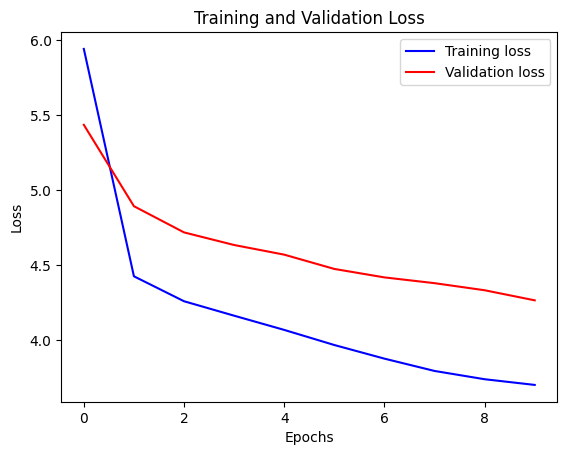

In [655]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [656]:
test_predictions = model.predict(test_dataset).flatten()
test_predictions = pd.DataFrame(data={'Predict':test_predictions})

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step


In [657]:
test_actuals = test_df_sc.iloc[:len(test_predictions), [0]]
test_actuals.sort_index(inplace=True)
test_actuals['Mean']  = test_actuals['Outcome'].mean()

In [658]:
test_predictions = pd.concat([
        test_actuals, 
        test_predictions.set_index(test_actuals.index)
    ], axis=1)

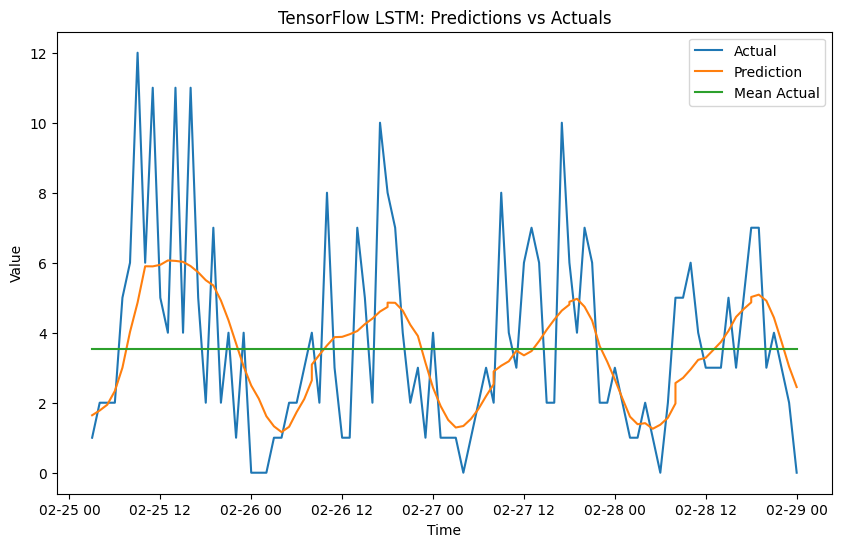

In [663]:
minplot = 1000
maxplot = 1100

plt.figure(figsize=(10, 6))
plt.plot(test_predictions['Outcome'][minplot:maxplot], label="Actual")
plt.plot(test_predictions['Predict'][minplot:maxplot], label="Prediction")
plt.plot(test_predictions['Mean'][minplot:maxplot], label="Mean Actual")

# Add legend
plt.legend()

# Add title and axis labels for context
plt.title("TensorFlow LSTM: Predictions vs Actuals")
plt.xlabel("Time")
plt.ylabel("Value")

plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


ValueError: x and y must have same first dimension, but have shapes (24,) and (1,)

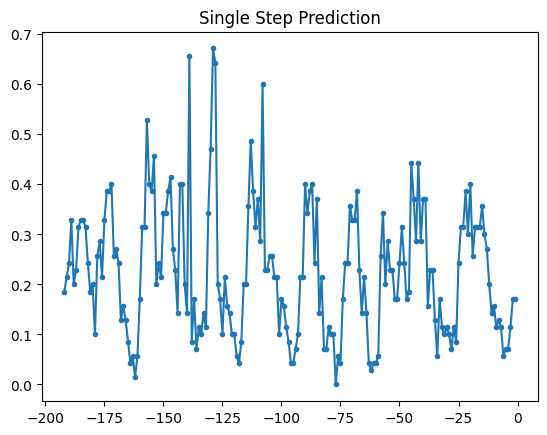

In [ ]:
def show_plot(plot_data, future, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]

    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = list(range(future_steps))

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i == 0:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        else:            
            plt.plot(future, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    #plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

future_steps = 24
for x, y in test_dataset.take(5):
    show_plot(
        #[x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        #1,
        [x[0][:, 1].numpy(),
          y[0].numpy()[:future_steps],
            model.predict(x)[0][:future_steps]],
        future_steps,
        "Single Step Prediction",
    )


In [ ]:
jhkfu

## Build a model

In [38]:
def make_net(number_features, 
             hidden_layers=3, 
             hidden_layer_neurones=128, 
             dropout=0.0, 
             learning_rate=0.003):
    
    """Make TensorFlow neural net"""
    
    # Clear Tensorflow 
    K.clear_session()
    
    # Set up neural net
    net = Sequential()
    
    # Add hidden hidden_layers using a loop
    for i in range(hidden_layers):
        # Add fully connected layer with ReLu activation
        net.add(Dense(
            hidden_layer_neurones, 
            input_dim=number_features,
            activation='relu'))
        # Add droput layer
        net.add(Dropout(dropout))
    
    # Add final sigmoid activation output
    net.add(Dense(1, activation='linear'))    
    #    net.add(Dense(1, activation='sigmoid'))    

    # Compiling model
    opt = Adam(learning_rate=learning_rate)
    
    net.compile(loss='mse', 
                optimizer=opt, 
                metrics=['mae'])
    
    return net

In [39]:
def calculate_site_accuracy(df,model, X_train, X_test, y_train, y_test):
    """Calculate and print accuracy at site level of training and test data fits"""    
    
    X_df = df.drop('Outcome',axis=1)
    site_columns = X_df.columns[X_df.columns.str.startswith('Site_')]

    results = []

    for site in site_columns:
        
        # Get the column index for the site
        site_idx = X_df.columns.get_loc(site)

        # Filter array where site column equals 1
        test_index = np.where(X_test[:, site_idx] == 1)[0]  
        site_X_test = X_test[test_index]
        site_y_test = y_test[test_index]

        train_index = np.where(X_train[:, site_idx] == 1)[0]  
        site_X_train = X_train[train_index]
        site_y_train = y_train[train_index]

        # Predict on training and test data
        print(f'{site}: col {site_idx}')
        site_y_pred_train = model.predict(site_X_train).flatten()
        site_y_pred_test = model.predict(site_X_test).flatten()
    
        # Calculate Mean Absolute Error (MAE) for training and test sets
        site_mae_train = np.mean(np.abs(site_y_pred_train - site_y_train))
        site_mae_test = np.mean(np.abs(site_y_pred_test - site_y_test))
        
        # Calculate Mean Squared Error (MSE) for training and test sets
        site_mse_train = np.mean((site_y_pred_train - site_y_train) ** 2)
        site_mse_test = np.mean((site_y_pred_test - site_y_test) ** 2)

        # Calculate Root Mean Squared Error (RMSE) for training and test sets
        site_rmse_train = np.sqrt(site_mse_train)
        site_rmse_test = np.sqrt(site_mse_test)

        # Calculate NRMSE (Normalized RMSE)
        range_y_train = np.max(site_y_train) - np.min(site_y_train)  # Range of y_train
        range_y_test = np.max(site_y_test) - np.min(site_y_test)  # Range of y_test
        site_nrmse_train = site_rmse_train / range_y_train
        site_nrmse_test = site_rmse_test / range_y_test

        # Calculate R^2 for training and test sets
        ss_total_train = np.sum((site_y_train - np.mean(site_y_train)) ** 2)
        ss_total_test = np.sum((site_y_test - np.mean(site_y_test)) ** 2)
        ss_residual_train = np.sum((site_y_pred_train - site_y_train) ** 2)
        ss_residual_test = np.sum((site_y_pred_test - site_y_test) ** 2)

        r2_train = 1 - (ss_residual_train / ss_total_train)
        r2_test = 1 - (ss_residual_test / ss_total_test)

        ## results
        site_result = {'Site':site
                    ,'MAE train':site_mae_train                   
                    ,'MAE test':site_mae_test
                    ,'MSE train':site_mse_train
                    ,'MSE test':site_mse_test
                    ,'NRMSE train':site_nrmse_train
                    ,'NRMSE test':site_nrmse_test
                    ,'r2 train':r2_train
                    ,'r2 test':r2_test
                    }

        results.append(site_result)

    results = pd.DataFrame(results)

    return results

In [40]:
def plot_training(history_dict,measure='mae'):
    acc_values = history_dict[measure]
    val_acc_values = history_dict[f'val_{measure}']
    epochs = range(1, len(acc_values) + 1)

    fig, ax = plt.subplots()

    ax.set_xlabel('Time')
    ax.set_ylabel(measure)

    ax.plot(epochs, acc_values, color='blue', label=f'Training {measure}')
    ax.plot(epochs, val_acc_values, color='red', label=f'Test {measure}')
    ax.set_title(f'Training and validation {measure}')
    
    ax.legend()

    fig.show()

In [41]:
model = make_net(number_features=X_train.shape[1], 
             hidden_layers=3, 
             hidden_layer_neurones=128, 
             dropout=0.10, 
             learning_rate=0.003)

In [42]:
# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'model_checkpoint.keras', save_best_only=True)

# Define early stopping callback
# Stop when no validation improvement for 25 epochs
# Restore weights to best validation accuracy
early_stopping_cb_loss = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True, monitor='val_loss')

#early_stopping_cb_acc = keras.callbacks.EarlyStopping(
#    patience=5, restore_best_weights=True, monitor='val_accuracy')


### Train model (and store training info in history)
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[checkpoint_cb
                               , early_stopping_cb_loss
                               #, early_stopping_cb_acc
                               ])

Epoch 1/200
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 2.8387 - mae: 1.2290 - val_loss: 2.4191 - val_mae: 1.1374
Epoch 2/200
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.4840 - mae: 1.1529 - val_loss: 2.3341 - val_mae: 1.1304
Epoch 3/200
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.3993 - mae: 1.1373 - val_loss: 2.3662 - val_mae: 1.1190
Epoch 4/200
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.3973 - mae: 1.1349 - val_loss: 2.3302 - val_mae: 1.1224
Epoch 5/200
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.3543 - mae: 1.1277 - val_loss: 2.3227 - val_mae: 1.1337
Epoch 6/200
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.3386 - mae: 1.1240 - val_loss: 2.3259 - val_mae: 1.1581
Epoch 7/200
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.3398 - mae: 1.1248 - val_loss: 2.2920 - val_mae: 1.1329
Epoch 8/200
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2.3414 - mae: 1.1263 - val_loss: 2.3451 - val_mae: 1.1321
Epoch 9/200
3807/3807 ━━━━━━

## Accuracy

In [43]:
## Baseline accuracy is the mean of site, month, weekday, hour
keras_calculate_baseline_accuracy(base_y_pred_train
                                ,base_y_pred_test
                                ,base_y_train
                                ,base_y_test)


Training MAE: 2.174
Test MAE: 2.140
Training MSE: 8.258
Test MSE: 8.029
Training NRMSE: 0.125
Test NRMSE: 0.113
Training R2: -0.106
Test R2: 0.643


In [44]:
keras_calculate_accuracy(model, X_train, X_test, y_train, y_test)

7614/7614 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Training MAE: 1.101
Test MAE: 1.110
Training MSE: 2.198
Test MSE: 2.248
Training NRMSE: 0.064
Test NRMSE: 0.060
Training R2: 0.607
Test R2: 0.602


In [45]:
site_results = calculate_site_accuracy(df,model
                                       , X_train
                                       , X_test
                                       , y_train
                                       , y_test)

Site_DARLINGTON MEMORIAL HOSPITAL: col 18
635/635 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Site_NORTHUMBRIA SPECIALIST EMERGENCY CARE HOSPITAL: col 19
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Site_QUEEN ELIZABETH HOSPITAL: col 20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Site_REDCAR PRIMARY CARE HOSPITAL: col 21
633/633 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Site_SOUTH TYNESIDE DISTRICT HOSPITAL: col 22
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
Site_SUNDERLAND ROYAL HOSPITAL: col 23
633/633 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
Site_THE JAMES COOK UNIVERSITY HOSPITAL: col 24
633/633 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Site_THE ROYAL VICTORIA INFIRMARY: col 25
635/635 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step
212/212 ━━━━━━━━━━━━━━

In [46]:
site_results

,Site,MAE train,MAE test,MSE train,MSE test,NRMSE train,NRMSE test,r2 train,r2 test
0,Site_DARLINGTON MEMORIAL HOSPITAL,1.117326,1.113103,2.147296,2.132539,0.097691,0.097355,0.385617,0.371936
1,Site_NORTHUMBRIA SPECIALIST EMERGENCY CARE HOS...,1.280928,1.271952,2.701083,2.713988,0.109566,0.102964,0.508731,0.505322
2,Site_QUEEN ELIZABETH HOSPITAL,1.177680,1.199877,2.305181,2.412997,0.108449,0.119491,0.408973,0.405025
3,Site_REDCAR PRIMARY CARE HOSPITAL,0.672485,0.694500,0.839489,0.926636,0.091624,0.106958,0.372369,0.348492
4,Site_SOUTH TYNESIDE DISTRICT HOSPITAL,0.768635,0.776452,0.970418,1.013150,0.098510,0.111839,0.380240,0.369488
5,Site_SUNDERLAND ROYAL HOSPITAL,1.181663,1.216194,2.319851,2.473918,0.108793,0.104858,0.381454,0.375581
6,Site_THE JAMES COOK UNIVERSITY HOSPITAL,1.258224,1.283938,2.757415,2.892954,0.072198,0.089519,0.567226,0.552036
7,Site_THE ROYAL VICTORIA INFIRMARY,1.343928,1.338220,2.975939,2.969943,0.101476,0.114890,0.456082,0.445299
8,Site_UNIVERSITY HOSPITAL OF HARTLEPOOL,0.910809,0.923689,1.500671,1.543566,0.102085,0.103534,0.470022,0.468809
9,Site_UNIVERSITY HOSPITAL OF NORTH DURHAM,1.261382,1.277318,2.794069,2.840335,0.111436,0.112355,0.510486,0.511391


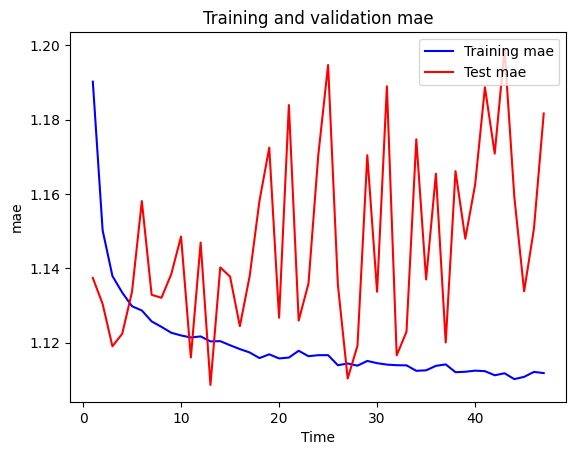

In [47]:
plot_training(history.history,measure='mae')

7614/7614 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


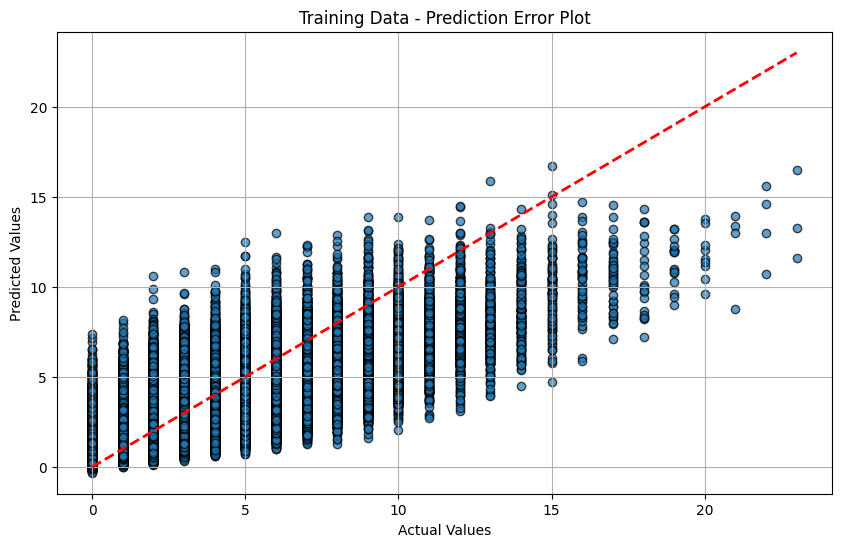

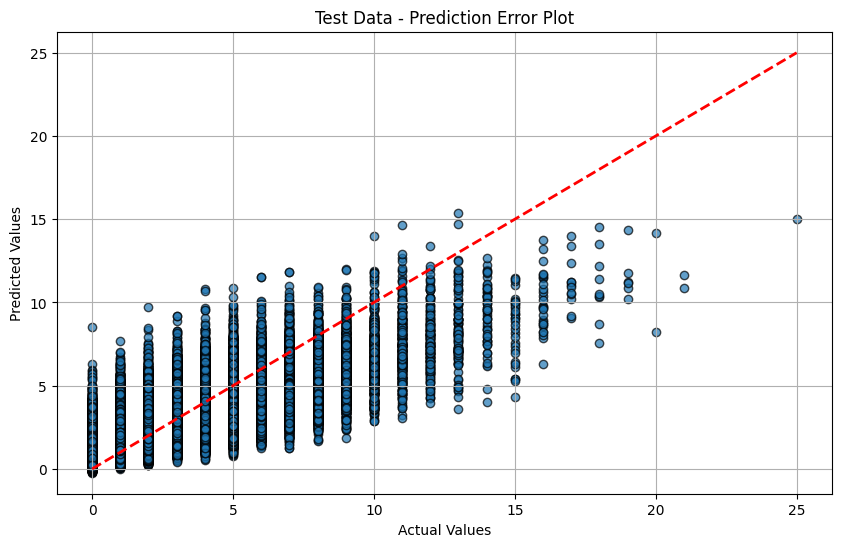

In [48]:
# Generate predictions
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

# Plot errors for both training and test data
plot_prediction_error(y_train, y_pred_train, title='Training Data - Prediction Error Plot')
plot_prediction_error(y_test, y_pred_test, title='Test Data - Prediction Error Plot')

7614/7614 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
2538/2538 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


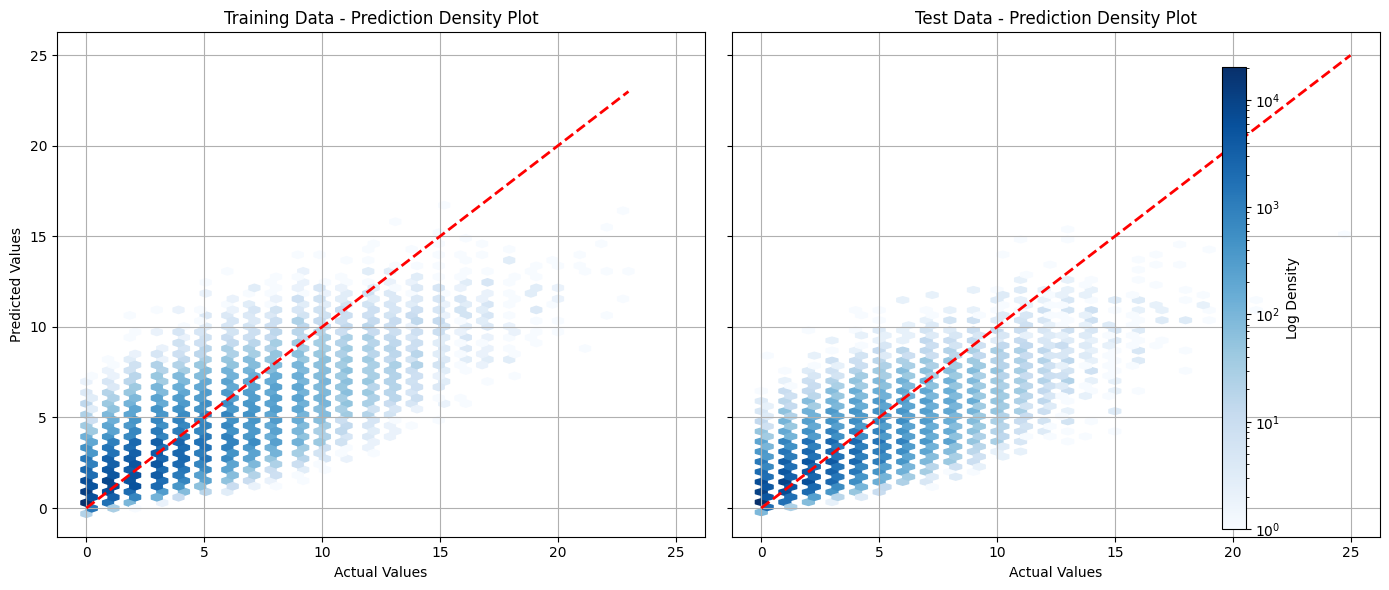

In [49]:
# Generate predictions
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

# Plot the density plots as subplots
plot_prediction_density_subplots(y_train, y_pred_train, y_test, y_pred_test)


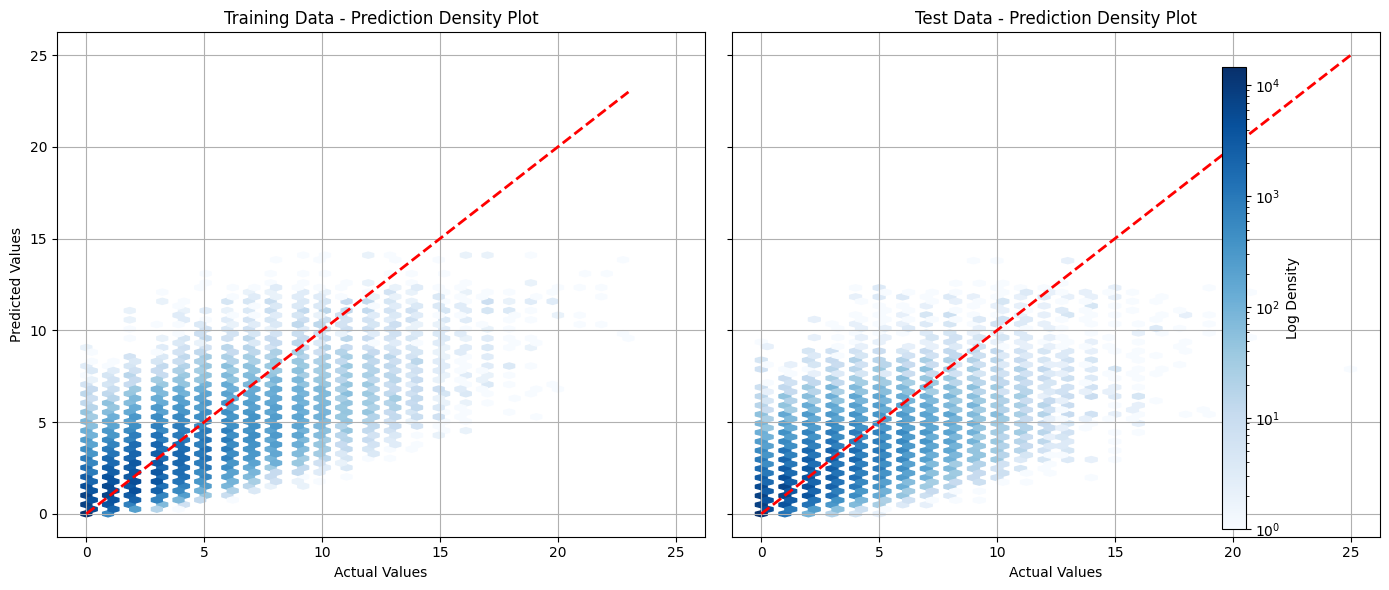

In [50]:
plot_prediction_density_subplots(base_y_train
                                 , base_y_pred_train
                                 , base_y_test
                                 , base_y_pred_test)